# Structure, Systems, Dataset and Loader Tutorial

# Topics:
- Interacting with `Structure` class
- Interacting `PlinderSystem`
- Interacting `PlinderDataset`
- Loader



## Setup

### Installation

`plinder` is available on *PyPI*.

```
pip install plinder
```

### Environment variable configuration
:::{note}
We need to set environment variables to point to the release and iteration of choice.
For the sake of demonstration, this will be set to point to a smaller tutorial example
dataset, which are `PLINDER_RELEASE=2024-06` and `PLINDER_ITERATION=tutorial`.
:::
:::{note}

## Getting the configuration

At first we get the configuration to check that all parameters are correctly set. 
In the snippet below, we will check, if the local and remote *PLINDER* paths point to
the expected location.

In [1]:
# %env PLINDER_MOUNT=/Users/vladas/Projects/public/plinder/tests/test_data
# %env PLINDER_RELEASE=mount
# %env PLINDER_BUCKET=plinder
# %env PLINDER_ITERATION=
# %env PLINDER_OFFLINE=

In [2]:
import plinder.core.utils.config

cfg = plinder.core.get_config()
print(f"local cache directory: {cfg.data.plinder_dir}")
print(f"remote data directory: {cfg.data.plinder_remote}")

local cache directory: /Users/vladas/.local/share/plinder/2024-06/v2
remote data directory: gs://plinder/2024-06/v2


## Data ecosystem overview
This tutorial assumes user have downloaded _PLINDER_ dataset before now. While the examples will run without users doing anything, we encourage users to download the data for performance sake. _PLINDER_ data hierarchy is shown below. We have organized this tutorial to follow this same hierarchy from ground up
![image](../static/asset/data/plinder_data_hierarchy.png)

## 0. Structure files

After download all files will be store locally at `~/.local/share/plinder/${PLINDER_RELEASE}/${PLINDER_ITERATION}/systems`. The current default is `PLINDER_RELEASE=2024-06` and `PLINDER_ITERATION-v2`

There, we have sub-folders that corresponds to each systems. In each sub-folder, we have:
- Receptor PDB: receptor.cif and receptor.pdb
- Ligand SDF's: `<biounit_instance_id>.<chain_id>.sdf`. For complexes with more than one ligands, all the sdfs are saved separately.
- Sequence fasta: sequence.fasta
For more information on the file organization, see "<link-to-dataset-tutorial>"

## 1. Structure Python Abstraction
To make interacting with our data seamless, {class} class Structure, a pydantic data class that:
- Loads all the structure files + smiles 
- Gets coordinates
- Featurizes residues and atoms of associated protein and ligand molecules
- Masks molecules to account for resolved vs unresolved part

To interact with the example, do the following:

In [3]:
from plinder.core.structure.structure import Structure
from plinder.core import PlinderSystem
from pathlib import Path

from biotite.sequence.io.fasta import FastaFile

# Load holo structure
holo_struc = PlinderSystem(system_id="1avd__1__1.A__1.C")
# .holo_structure

In [4]:
holo_struc.holo_structure

2024-09-24 11:48:51,078 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:51,078 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:51,781 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:51,782 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:51,782 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-09-24 11:48:51,787 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-09-24 11:48:51,787 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 0.71s


Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        {
            '1.A': 'ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRTQKE',
        },
    ),
    (
        'ligand_sdfs',
        {
            '1.C': '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf',
        },
    ),
    (
        'ligand_smiles',
        {
            '1.C': 'CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O',
        },
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    <class 'numpy.ndarray'> with shape (1, 14),
                    <class 'numpy.nd

### Load the structure for a given system_id
For this purpose we will use `"1avd__1__1.A__1.C"` as our example system id.

In [5]:
from plinder.core.structure.structure import Structure
from plinder.core import PlinderSystem
from pathlib import Path

from biotite.sequence.io.fasta import FastaFile

input_smiles = "CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O" # Need to account for unresolved part of the ligand
input_sdf = Path(cfg.data.plinder_dir)/"systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf"
system_id = "1avd__1__1.A__1.C"
protein_structure_path = Path(cfg.data.plinder_dir)/"systems/1avd__1__1.A__1.C/receptor.cif"
input_sequence_path = Path(cfg.data.plinder_dir)/"systems/1avd__1__1.A__1.C/sequences.fasta"
list_ligand_sdf_and_input_smiles = [
    (input_sdf,input_smiles)]

input_sequences = {k: v for k, v in FastaFile.read_iter(input_sequence_path)}

# Load holo structure
holo_struc = PlinderSystem(system_id=system_id).holo_structure

2024-09-24 11:48:52,794 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:52,795 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:53,456 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:53,457 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:48:53,457 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-09-24 11:48:53,460 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-09-24 11:48:53,460 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 0.66s


In [6]:
# Show fields
holo_struc.model_fields

{'id': FieldInfo(annotation=str, required=True),
 'protein_path': FieldInfo(annotation=Path, required=True),
 'protein_sequence': FieldInfo(annotation=Union[dict[str, str], NoneType], required=False, default=None),
 'ligand_sdfs': FieldInfo(annotation=Union[dict[str, str], NoneType], required=False, default=None),
 'ligand_smiles': FieldInfo(annotation=Union[dict[str, str], NoneType], required=False, default=None),
 'protein_atom_array': FieldInfo(annotation=Union[AtomArray, NoneType], required=False, default=None),
 'ligand_mols': FieldInfo(annotation=Union[dict[str, tuple[Mol, Mol, Mol, tuple[ndarray[Any, dtype[+_ScalarType_co]], ndarray[Any, dtype[+_ScalarType_co]]]]], NoneType], required=False, default=None),
 'add_ligand_hydrogens': FieldInfo(annotation=bool, required=False, default=False),
 'structure_type': FieldInfo(annotation=str, required=False, default='holo')}

### List fields
- We list all fields and their `FieldInfo` to show which ones are required. `id`, `protein_path` and `protein_sequence` are required. Everything else is optionally. Particularly worth mentioning is the decision to make `list_ligand_sdf_and_input_smiles` optional; this is because ligand will not be availbale in apo and predicted structures.
- Out of these field `ligand_mols` and `protein_atom_array` is computed within the object if set to default. 
- `ligand_mols` returns a chain-mapped dictionary of of the form:
    ```python
    {
        "<instance_id>.<chain_id>": (
            RDKit 2D mol from template SMILES of type `Chem.Mol`,
            RDKit mol from template SMILES with random 3D conformer of type `Chem.Mol`,
            RDKit mol of solved (holo) ligand structure of type `Chem.Mol`,
            paired stacked arrays (template vs holo) mapping atom order by index of type `tuple[NDArray.int_, NDArray.int_]`
        )

    }
    ```
- While `protein_atom_array` returns [biotite AtomArray](https://www.biotite-python.org/latest/apidoc/biotite.structure.AtomArray.html) of the receptor protein structure.
- `add_ligand_hydrogens` specifies whether to adds hydrogens to ligand
- `structure_type`: could be `"holo"`, `"apo"` or `"pred"`

In [7]:
# Inspect ligand_mols
holo_struc.ligand_mols

{'1.C': (<rdkit.Chem.rdchem.Mol at 0x1c7cd52a0>,
  (array([[13,  4,  5,  7,  9, 10,  1,  0,  3,  6,  8, 12, 11,  2]]),
   array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])))}

In [8]:
holo_struc.ligand_smiles

{'1.C': 'CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O'}

In [9]:
# Inspect protein_atom_araay

In [10]:
holo_struc.protein_atom_array[0]

Atom(np.array([31.221, 22.957, 43.101], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="N", element="N", b_factor=0.0)

### List structure protein properties
Show protein related properties

In [11]:
for property in holo_struc.get_properties():
    if "protein" in property:
        print(property)

protein_backbone_mask
protein_calpha_coords
protein_calpha_mask
protein_chain_ordered
protein_chains
protein_coords
protein_n_atoms
protein_sequence_from_structure
protein_structure_b_factor
protein_structure_tokenized_sequence
protein_unique_atom_names
protein_unique_residue_ids
protein_unique_residue_names


#### Protein backbone mask
This is a boolean mask that can be used to select backbone atoms from biotite `AtomArray`. The indices of `True` corresponds to backbone indices.

In [12]:
holo_struc.protein_backbone_mask

array([ True,  True,  True, False, False, False, False, False, False,
        True,  True,  True, False, False, False,  True,  True,  True,
       False, False, False,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False,  True,

#### Protein Calpha mask
This shows the mask of calpha atoms

In [13]:
holo_struc.protein_calpha_mask

array([False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,

### Get protein chain ordered
This gives a list of protein chains ordered by how they are in the structure

In [14]:
holo_struc.protein_chain_ordered

['1.A']

### Get protein chain ordered
This gives a list of protein chains ordered by how they are in the structure

### Get protein chains for all atoms
The list of chain IDs in the structure. Order of how they appear not kept.

In [15]:
holo_struc.protein_chains

['1.A']

### Get protein coordinates
This property gets the 3D positions of each of the atoms in protein molecules

In [16]:
holo_struc.protein_coords

[array([[31.221, 22.957, 43.101],
        [31.828, 24.118, 42.476],
        [31.979, 23.854, 41.021],
        ...,
        [34.341, 35.018, 24.674],
        [35.484, 35.831, 24.497],
        [33.105, 35.742, 24.15 ]], dtype=float32)]

### Get number of atoms of protein molecule

In [17]:
holo_struc.protein_n_atoms

964

### Get protein structure atom names
Returns all atoms names the same way they appear in the structure

In [18]:
holo_struc.protein_unique_atom_names

['C',
 'CA',
 'CB',
 'CD',
 'CD1',
 'CD2',
 'CE',
 'CE1',
 'CE2',
 'CE3',
 'CG',
 'CG1',
 'CG2',
 'CH2',
 'CZ',
 'CZ2',
 'CZ3',
 'N',
 'ND1',
 'ND2',
 'NE',
 'NE1',
 'NE2',
 'NH1',
 'NH2',
 'NZ',
 'O',
 'OD1',
 'OD2',
 'OE1',
 'OE2',
 'OG',
 'OG1',
 'OH',
 'SD',
 'SG']

### Get protein b-factors
Get protein atom occupancies. If not available in a structure, it's set to zero.

In [19]:
holo_struc.protein_structure_b_factor

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

### Get protein residue names

In [20]:
holo_struc.protein_unique_residue_names

['ALA',
 'ARG',
 'ASN',
 'ASP',
 'CYS',
 'GLN',
 'GLU',
 'GLY',
 'HIS',
 'ILE',
 'LEU',
 'LYS',
 'MET',
 'PHE',
 'PRO',
 'SER',
 'THR',
 'TRP',
 'TYR',
 'VAL']

### Get protein residues number
Residue number as they appear in structure

In [21]:
holo_struc.protein_unique_residue_ids

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125]

### Get sequence from protein structure


In [22]:
holo_struc.protein_sequence_from_structure

'KCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRT'

In [23]:
holo_struc.protein_sequence

{'1.A': 'ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRTQKE'}

### Get tokenized sequence
Get tensor of sequence converted to integer-based amino acid token

In [24]:
holo_struc.protein_structure_tokenized_sequence

tensor([11,  4, 15, 10, 16,  7, 11, 17, 16,  2,  3, 10,  7, 15,  2, 12, 16,  9,
         7,  0, 19,  2, 15,  1,  7,  6, 13, 16,  7, 16, 18, 16, 16,  0, 19, 16,
         0, 16, 15,  2,  6,  9, 11,  6, 15, 14, 10,  8,  7, 16,  6,  2, 16,  9,
         2, 11,  1, 16,  5, 14, 16, 13,  7, 13, 16, 19,  2, 17, 11, 13, 15,  6,
        15, 16, 16, 19, 13, 16,  7,  5,  4, 13,  9,  3,  1,  2,  7, 11,  6, 19,
        10, 11, 16, 12, 17, 10, 10,  1, 15, 15, 19,  2,  3,  9,  7,  3,  3, 17,
        11,  0, 16,  1, 19,  7,  9,  2,  9, 13, 16,  1, 10,  1, 16])

#### Inspect holo sequences
Returns a chain-mapped dictionary of sequences from seqres
```python
{
    "<instance_id>.<chain_id>": sequence of type `str`

}
```

In [25]:
holo_struc.protein_sequence

{'1.A': 'ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRTQKE'}

In [26]:
holo_struc.filter(
        property="atom_name",
        mask="CA",

    )

Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        {
            '1.A': 'ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRTQKE',
        },
    ),
    (
        'ligand_sdfs',
        {
            '1.C': '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf',
        },
    ),
    (
        'ligand_smiles',
        {
            '1.C': 'CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O',
        },
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (123,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    <class 'numpy.ndarray'> with shape (1, 14),
                    <class 'numpy.nd

### List ligand properties
Show ligand related properties

In [27]:
for property in holo_struc.get_properties():
    if "ligand" in property:
        print(property)

input_ligand_conformer_atom_array
input_ligand_conformers
input_ligand_conformers_coords
input_ligand_templates
ligand_atom_array
ligand_chain_ordered
ligand_template2resolved_atom_order_stacks
resolved_ligand_mols
resolved_ligand_mols_coords


:::{todo}

The input ligands are provided using dictionaries.
These dictionaries contain information for each ligand:
- input_ligand_templates: 2D RDKit mols generated from RDKit canonical SMILES (taken from annotation table)
- input_ligand_conformers: 3D (random) conformers generated for each input mol
- input_ligand_conformers_coords: positional coordintates for 3D conformers
- resolved_ligand_mols: RDKit mols of solved (holo) ligand structures
- resolved_ligand_mols_coords: positional coordintates for holo ligand structures
- ligand_template2resolved_atom_order_stacks: paired stacked arrays (template vs holo) mapping atom order by index
- ligand_chain_ordered: ordered list of all ligands by their keys

:::

### Ligand atom id mapping mapping

Unlike the protein sequence - there is no canonical order to ligand atoms in the molecule.
It can be further complicated by automorphisms present in the structure due to symmetry, i.e. there is more than one match that is possible between the structures.

This is important when calculating ligand structure loss, as the most optimal atom order can change between the different inference results. Typically, it is accepted to take the atom ordering resulting in the best objective score and use that for the loss calculation.

Occasionally futher ambiguity arises to to part of the ligand structure being unresolved in the holo structure - this can lead to multiple available matches. We use RascalMCES algorithm from RDKit to provide all the possible matches between the atom order in the input structure (from SMILES) to the resolved holo structure.

This is provided as stacks of atom order arrays that reorder the template and holo indices to provide matches. Each stack is a unique order transformation and should be iterated.

### Ligand conformer to input smiles mapping

Each RDKit ligand mol that is generated from SMILES matches the atom order that is in the starting SMILES.
This order is retained when 3D conformer is generated.

! NOTE: While we ensure that each PLINDER ligand can be loaded and sanitized into RDKit 2D molecule, some ligands may struggle to generate sanitizeable 3D conformers. We nonetheless are trying to provide each ligand with as sensible starting structure as possible and make it accessible via coordinate arrays.

In [28]:
# sample_system_2 = PlinderSystem(
#     system_id="102m__1__1.A__1.C",
# )
# sample_system_2.holo_structure.ligand_mols['1.C'][1]

In [29]:
holo_struc.ligand_template2resolved_atom_order_stacks

{'1.C': (array([[13,  4,  5,  7,  9, 10,  1,  0,  3,  6,  8, 12, 11,  2]]),
  array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]]))}

Below we use RDKit functionality to draw indixes for `'1.C'` ligand 2D, conformer and holo structures

In [30]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

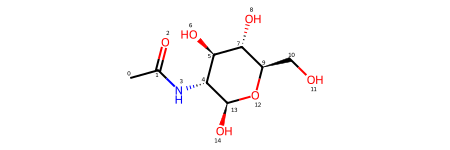

In [31]:
holo_struc.input_ligand_templates["1.C"]

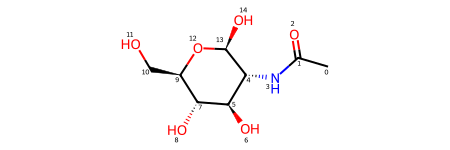

In [32]:
holo_struc.input_ligand_conformers["1.C"]

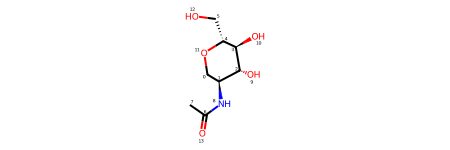

In [33]:
holo_struc.resolved_ligand_mols["1.C"]

### Ligand conformer coordinates

As you can tell, the input 2D and 3D conformer indices match, but the resolved ligand is different.
Thus to perform a correct comparison for their coordinates one should use atom order stacks.


In [34]:
input_atom_order_stack, holo_atom_order_stack = holo_struc.ligand_template2resolved_atom_order_stacks["1.C"]

In [35]:
holo_struc.resolved_ligand_mols_coords['1.C']

array([[36.097, 24.731, 18.551],
       [36.841, 24.28 , 17.298],
       [38.191, 24.996, 17.307],
       [37.93 , 26.507, 17.335],
       [37.118, 26.889, 18.595],
       [36.636, 28.326, 18.719],
       [35.948, 22.08 , 16.874],
       [34.96 , 22.767, 15.881],
       [36.989, 22.845, 17.232],
       [38.879, 24.744, 16.078],
       [39.175, 27.211, 17.276],
       [35.883, 26.133, 18.477],
       [35.31 , 28.501, 19.242],
       [35.767, 20.938, 17.325]])

In [36]:
holo_struc.input_ligand_conformers_coords['1.C'][holo_atom_order_stack]

array([[[ 4.3813846 ,  0.41928008, -0.94581396],
        [ 3.05057178,  0.80964945, -0.36443604],
        [ 2.88393027,  1.84542537,  0.27279943],
        [ 2.03926275, -0.0932829 , -0.59307729],
        [ 0.73567666,  0.05273174,  0.07102964],
        [-0.05178081, -1.26281853, -0.04161451],
        [ 0.70773615, -2.34070956,  0.53053007],
        [-1.41155424, -1.15850518,  0.66048274],
        [-2.10024692, -2.39521192,  0.44904366],
        [-2.17464716,  0.04574057,  0.09595386],
        [-3.48989133,  0.28955041,  0.84148991],
        [-4.15835844,  1.41704912,  0.27817669],
        [-1.39221873,  1.24117422,  0.23460389],
        [-0.16285811,  1.19076378, -0.4944873 ]]])

## 2. Interacting with PLINDER systems
PlinderSystem is the next layer of abstraction above `Structure`. It provides encapsulation around all structures associated with a particular `system_id`. With these, we can access the `holo` and alternate (`apo` and `pred`) structure.

In [37]:
sample_system = PlinderSystem(
    system_id="1avd__1__1.A__1.C",
)

### Check holo structure
Since having `holo` structure is a defining feature of _PLINDER_ system, holo structures is by definition available for all systems 

In [38]:
sample_system.holo_structure

2024-09-24 11:49:14,467 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:49:14,468 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:49:15,133 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:49:15,135 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:49:15,136 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-09-24 11:49:15,142 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-09-24 11:49:15,143 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 0.67s


Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        {
            '1.A': 'ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRTQKE',
        },
    ),
    (
        'ligand_sdfs',
        {
            '1.C': '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf',
        },
    ),
    (
        'ligand_smiles',
        {
            '1.C': 'CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O',
        },
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    <class 'numpy.ndarray'> with shape (1, 14),
                    <class 'numpy.nd

### Get annotations 
This `system` property returns `json` data of annotations for a the system in question. To get the annotations of all other systems sharing the same PDB entry ids, use `.entry` property.

In [39]:
sample_system.system

{'pdb_id': '1avd',
 'biounit_id': '1',
 'ligands': [{'pdb_id': '1avd',
   'biounit_id': '1',
   'asym_id': 'C',
   'instance': 1,
   'ccd_code': 'NAG',
   'plip_type': 'SMALLMOLECULE',
   'bird_id': '',
   'centroid': [36.85636520385742, 25.090288162231445, 17.591215133666992],
   'smiles': 'CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O',
   'resolved_smiles': 'OC[C@H]1O[CH][C@@H]([C@H]([C@@H]1O)O)NC(=O)C',
   'residue_numbers': [1],
   'rdkit_canonical_smiles': 'CC(=O)N[C@@H]1[C@@H](O)[C@H](O)[C@@H](CO)O[C@H]1O',
   'molecular_weight': 221.0899372,
   'crippen_clogp': -3.077599999999999,
   'num_rot_bonds': 2,
   'num_hbd': 5,
   'num_hba': 6,
   'num_rings': 1,
   'num_heavy_atoms': 15,
   'is_covalent': True,
   'covalent_linkages': ['17:ASN:A:17:ND2__600:NAG:C:.:C1'],
   'neighboring_residues': {'1.A': [9, 11, 15, 16, 17, 34, 35, 36, 123]},
   'neighboring_ligands': [],
   'interacting_residues': {'1.A': [34, 15]},
   'interacting_ligands': [],
   'interactions': {'1.A': {'15':

### Get paths of the underlying structure files

`archive` points to the subfolder where all the files (except `apo` and `pred` files) relating to a given system are stored

In [40]:
sample_system.archive

PosixPath('/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C')

Similarly, the  `system.cif`, `receptor.cif`, `receptor.pdb`, `sequence.fasta`, and ligand sdfs can be accessed via `.system_cif`, `.receptor_cif`, `.receptor_pdb`, `.sequence_fasta` and `.ligand_sdf` properties respectively. 

To get all the paths of the structures together, use `.structures`

In [41]:
sample_system.structures

['/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif',
 '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.pdb',
 '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/chain_mapping.json',
 '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta',
 '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/system.cif',
 '/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf']

In [42]:
sample_system.system_cif

'/Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/system.cif'

### Get binding site water (`.water_mapping`)
This returns the information about binding site water 

In [43]:
sample_system.water_mapping

### Chain mapping 
:::{todo}
Confirm with Jay
:::

`.chain_mapping` maps chain ids in system (`<instance_id>.<asym_id>`) to PDB author chain ids 

In [44]:
sample_system.chain_mapping

{'1.A': 'A'}

linked_structures, linked_archive, get_linked_structure 
linked_archive, linked_structures,  get_linked_structure, alt_structures

### Linked apo and predicted structures.
The following properties provides different kind of information about linked structures as described below:
- `.linked_archive`: returns paths the local subfolder where the linked structures are saved; 
- `.linked_structures`: returns the dataframe of linked structures along with all their metrics while 
- `.get_linked_structure`:  gives the path to a specific linked structure.
- `.best_linked_structures_paths`: Gives the best linked structures based on `scrmsd_wave` which is average symmetry-corrected RMSD across mapped ligands weighted by number of atoms. This selects maximum of two alternate structure with at most one `apo` and `pred` each when available
- `.alt_structures`: returns the dictionary`Structure` object of the best `apo` and `pred` which the corresponding `holo` chain as key

In [45]:
sample_system.linked_archive

2024-09-24 11:49:31,305 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-24 11:49:31,305 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s


  0%|          | 0/11 [00:00<?, ?it/s]

PosixPath('/Users/vladas/.local/share/plinder/2024-06/v2/linked_structures')

In [47]:
sample_system.linked_structures

,reference_system_id,id,pocket_fident,pocket_lddt,protein_fident_qcov_weighted_sum,protein_fident_weighted_sum,protein_lddt_weighted_sum,target_id,sort_score,receptor_file,...,posebusters_most_extreme_ligand_element_waters,posebusters_most_extreme_protein_element_waters,posebusters_most_extreme_ligand_vdw_waters,posebusters_most_extreme_protein_vdw_waters,posebusters_most_extreme_sum_radii_waters,posebusters_most_extreme_distance_waters,posebusters_most_extreme_sum_radii_scaled_waters,posebusters_most_extreme_relative_distance_waters,posebusters_most_extreme_clash_waters,kind
0,1avd__1__1.A__1.C,1vyo_B,100.0,83.0,98.0,98.0,93.0,1vyo,1.48,/plinder/2024-06/assignments/apo/1avd__1__1.A_...,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,apo
1,1avd__1__1.A__1.C,1vyo_A,100.0,82.0,98.0,98.0,93.0,1vyo,1.48,/plinder/2024-06/assignments/apo/1avd__1__1.A_...,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,apo
2,1avd__1__1.A__1.C,1nqn_A,100.0,76.0,94.0,99.0,88.0,1nqn,1.80,/plinder/2024-06/assignments/apo/1avd__1__1.A_...,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,apo
3,1avd__1__1.A__1.C,1rav_B,100.0,81.0,99.0,99.0,90.0,1rav,2.20,/plinder/2024-06/assignments/apo/1avd__1__1.A_...,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,apo
4,1avd__1__1.A__1.C,1rav_A,100.0,83.0,99.0,99.0,90.0,1rav,2.20,/plinder/2024-06/assignments/apo/1avd__1__1.A_...,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,apo
5,1avd__1__1.A__1.C,P02701_A,100.0,94.0,98.0,98.0,93.0,P02701,91.22,/plinder/2024-06/assignments/pred/1avd__1__1.A...,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pred


In [48]:
sample_system.get_linked_structure(link_kind="apo", link_id='1vyo_B')

'/Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/1vyo_B.cif'

In [49]:
sample_system.alternate_structures

{'1vyo_B': Structure(
     (
         'id',
         '1vyo_B',
     ),
     (
         'protein_path',
         /Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/1vyo_B.cif,
     ),
     (
         'protein_sequence',
         {
             '1.A': 'ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRTQKE',
         },
     ),
     (
         'ligand_sdfs',
         None,
     ),
     (
         'ligand_smiles',
         None,
     ),
     (
         'protein_atom_array',
         <class 'biotite.structure.AtomArray'> with shape (958,),
     ),
     (
         'ligand_mols',
         None,
     ),
     (
         'add_ligand_hydrogens',
         False,
     ),
     (
         'structure_type',
         'apo',
     ),
 ),
 '1vyo_A': Structure(
     (
         'id',
         '1vyo_A',
     ),
     (
         'protein_path',
         /Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/1vyo_A.

### Get `Openstructure` entities and views
`.receptor_entity` returns receptor `mol.EntityHandle` object
`.ligand_views` returns `mol.ResidueView` for all ligands

:::{note}
You must have Openstructure installed to use this property
:::


### Others properties
This includes:
- `num_ligands`: Number of ligand chains
- `smiles`: Ligand smiles dictionary
- `num_proteins`: Number of protein chains


## 3. Interacting with the PLINDER dataset
`PlinderDataset` provides an interface to interact with _PLINDER_ data as a dataset. It is a subclass of `torch.utils.data.Dataset`, as such subclassing it and extending should be familiar to most users. Flexibility and general applicability is our top concern when designing this interface and `PlinderDataset` allows users to not only define their own split but to also bring their own featurizer.
It can be initialized with the following parameters
```
Parameters
    ----------
    df : pd.DataFrame | None
        the split to use
    split : str
        the split to sample from
    split_parquet_path : str | Path, default=None
        split parquet file
    input_structure_priority : str, default="apo"
        Which alternate structure to proritize
    featurizer: Callable[
            [Structure, int], dict[str, torch.Tensor]
    ] = structure_featurizer,
        Transformation to turn structure to input tensors
    padding_value : int
        Value for padding uneven array
    **kwargs : Any
        Any other keyword args
``` 

#### Make _PLINDER_ training dataset with default parameters
When no parameter is set, PlinderDataset automatically defaults to the training set of the most current version of the dataset. To change this behaviour, we can explicitly pass a data frame to the parameter `df` or split file to `split_parquet_path`. Either of these must have at least two columns named `system_id` and `split`. This also use our default featurizer `plinder.core.loader.featurizer.featurizer`. 
NOTE: We have provided this `plinder.core.loader.featurizer.featurizer` as an example featurizer; users are encourage to use featurizers that suit their need.

In [51]:
from plinder.core.loader import PlinderDataset, get_torch_loader

In [52]:
val_dataset = PlinderDataset(split="val")
#train_dataset = PlinderDataset(df=splits_df[splits_df.system_id =="6pl9__1__1.A__1.C"])

2024-09-24 11:49:53,525 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.65s
2024-09-24 11:49:55,633 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.73s
2024-09-24 11:49:56,441 | plinder.core.split.utils:40 | INFO : reading /Users/vladas/.local/share/plinder/2024-06/v2/splits/split.parquet
2024-09-24 11:49:56,709 | plinder.core.split.utils.get_split:24 | INFO : runtime succeeded: 2.03s


This takes some time an memory - thus we only load on `val` here rather than `train`.

In [53]:
val_data = val_dataset[1]

2024-09-24 11:50:05,355 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 6.71s
2024-09-24 11:50:06,017 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.66s
2024-09-24 11:50:11,753 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 2.98s
2024-09-24 11:50:12,396 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.64s
2024-09-24 11:50:12,397 | plinder.core.index.utils:148 | INFO : loading entries from 1 zips
2024-09-24 11:50:12,401 | plinder.core.index.utils:163 | INFO : loaded 1 entries
2024-09-24 11:50:12,402 | plinder.core.index.utils.load_entries:24 | INFO : runtime succeeded: 4.28s
2024-09-24 11:50:12,522 | plinder.core.structure.atoms:123 | INFO : generate_conformer: MMFFOptimizeMolecule - more iterations are required, extending by 500 steps


test_data[110]

## 4. Loader

In [ ]:
val_loader = get_torch_loader(
    val_dataset
)

In [ ]:
for data in val_loader:

    test_torch = data
    break
    #for k, v in test_torch['input_features'].items():
    #    if v.shape[1] > 1:
    #        break

In [ ]:
test_torch.keys()

In [ ]:
test_torch['system_ids']

In [ ]:
for k, v in test_torch['features_and_coords'].items():
    print(k, v.shape)